# Nonlinear for systems of ODEs

In [27]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
torch.manual_seed(12)

## Generate training data

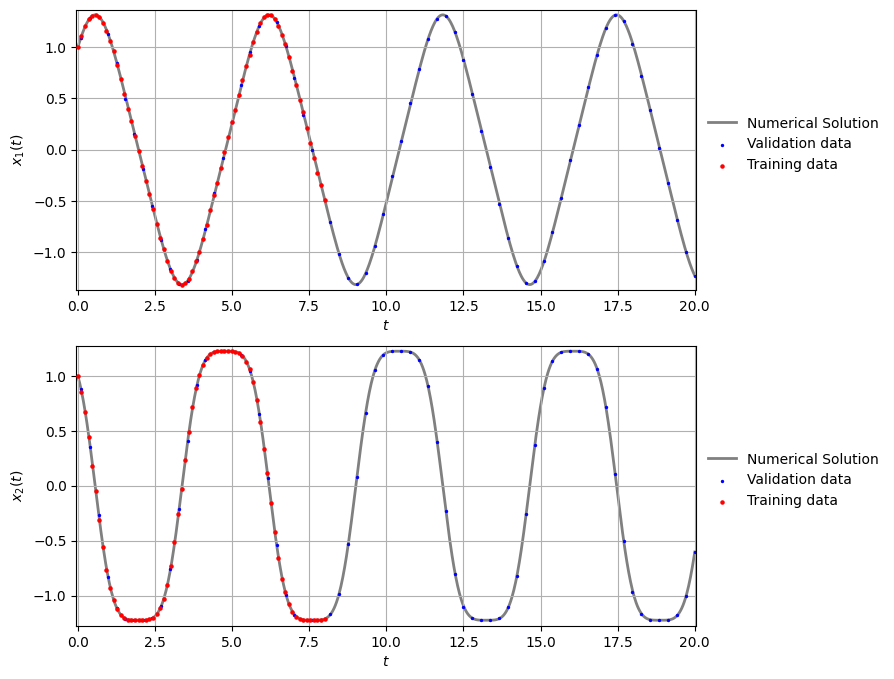

In [28]:
# Parameters and initial conditions
# w0^2 = g/L,

X0 = [1, 1]

# time domain
ti = 0
tf = 20
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

def f1(x1, x2, t):
    return x2

def f2(x1, x2, t):
    return -x1**3

# Numerical Solution
def ODE(X, t):
    dXdt = [f1(X[0], X[1], t), f2(X[0], X[1], t)]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 70
Noise_mean = 1
Noise_std  = 0
Noise      = torch.randn((N_training,2))*Noise_std + Noise_mean
t_data  = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]*Noise
x1_data = training_data[:,0].view(-1,1)
x2_data = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 70
t_val  = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val = validation_data[:,0].view(-1,1)
x2_val = validation_data[:,1].view(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(t, x1, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[0].scatter(t_val, x1_val, color="blue", label="Validation data", s=2, zorder=2)
axes[0].scatter(t_data, x1_data, color="red", label="Training data", s=5, zorder=3)
axes[0].set_xlim(ti-.05, tf+0.05)
axes[0].set_ylim(-x1_max-.05, x1_max+0.05)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x_1(t)$')
axes[0].legend(frameon=False, loc=(1.01, 0.40))
axes[0].grid()

axes[1].plot(t, x2, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[1].scatter(t_val, x2_val, color="blue", label="Validation data", s=2, zorder=2)
axes[1].scatter(t_data, x2_data, color="red", label="Training data", s=5, zorder=3)
axes[1].set_xlim(ti-.05, tf+0.05)
axes[1].set_ylim(-x2_max-.05, x2_max+0.05)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x_2(t)$')
axes[1].legend(frameon=False, loc=(1.01, 0.40))
axes[1].grid()

plt.show()

## PINN

In [29]:
def make_plot(
    i, loss_val, epochs,
    t, t_data, t_validation, t_collocation,
    solution_1, prediction_1,
    solution_2, prediction_2,
    data_1, data_2,
    validation_1, validation_2,
    x1_max, x2_max,
    training_loss, validation_loss
    
):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    fig.suptitle(f"Training Step {i} \n Validation Loss: {loss_val.item():.4f}", fontsize=16)

    axes[0,0].plot(t, solution_1, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[0,0].plot(t, prediction_1, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[0,0].scatter(t_data, data_1, color="red", label="Training data", s=5, zorder=3)
    axes[0,0].scatter(t_validation, validation_1, color="blue", label="Validation data", s=2, zorder=2)
    axes[0,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[0,0].set_xlim(ti-.05, tf+0.05)
    axes[0,0].set_ylim(-x1_max-.05, x1_max+0.05)
    axes[0,0].set_xlabel('$t$')
    axes[0,0].set_ylabel('$x_1(t)$')
    axes[0,0].legend(frameon=False, loc=(1.01, 0.48))
    axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[0,0].grid()

    axes[1,0].plot(t, solution_2, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[1,0].scatter(t_validation, validation_2, color="blue", label="Validation data", s=2, zorder=2)
    axes[1,0].scatter(t_data, data_2, color="red", label="Training data", s=5, zorder=3)
    axes[1,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[1,0].plot(t, prediction_2, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[1,0].set_xlim(ti-.05, tf+0.05)
    axes[1,0].set_ylim(-x2_max-.05, x2_max+0.05)
    axes[1,0].set_xlabel('$t$')
    axes[1,0].set_ylabel('$x_2(t)$')
    axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[1,0].grid()
    
    axes[0,1].plot(np.arange(i+1), training_loss, label="Training Loss", color='red', lw=1)
    axes[0,1].plot(np.arange(i+1), validation_loss, label="validation Loss", color='blue', lw=1)
    axes[0,1].set_xlabel('Training Steps')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].set_xlim(0, epochs)
    axes[0,1].set_ylim(1e-6, 1e2)
    axes[0,1].set_yscale('log')
    axes[0,1].grid()
    axes[0,1].legend(frameon=False, loc=(0.7, 1))
    
    
    X_max = max(x1_max, x2_max)
    axes[1,1].plot(t, torch.abs((solution_1 - prediction_1)), label="Error in $x_1$", color='red', lw=1)
    axes[1,1].plot(t, torch.abs((solution_2 - prediction_2)), label="Error in $x_2$", color='blue', lw=1)
    axes[1,1].set_xlabel('t')
    axes[1,1].set_ylabel('relative error')
    axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[1,1].set_ylim(1e-6, 1e4)
    axes[1,1].set_yscale('log')
    axes[1,1].grid()
    axes[1,1].legend(frameon=False, loc=(0.7, 1))
    
    plt.tight_layout()

In [30]:
# Define Neural Network Structure

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self):
        super().__init__()
        self.scale = lambda T : (T - ti)/(tf-ti)
        
        self.fcs = nn.Sequential(*[nn.Linear(1, 32), nn.Tanh()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()])
                    ])
        self.fce = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [31]:
# Define the sample locations for physics loss
N_phys = 200
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

Training step 0
x1 MSE = 8.0493e-01, x2 MSE = 9.5392e-01
Total Training Loss = 1.7613e+00, 
ODE Training Loss = 0.0000%, Data Training Loss = 99.8604%, derivative Training Loss = 0.1396%

x1 MSE = 9.2233e-01, x2 MSE = 9.8916e-01
Total Validation Loss = 1.9139e+00, 
ODE Validation Loss = 0.1276%, Data Validation Loss = 99.8724%
----------------------------------------------


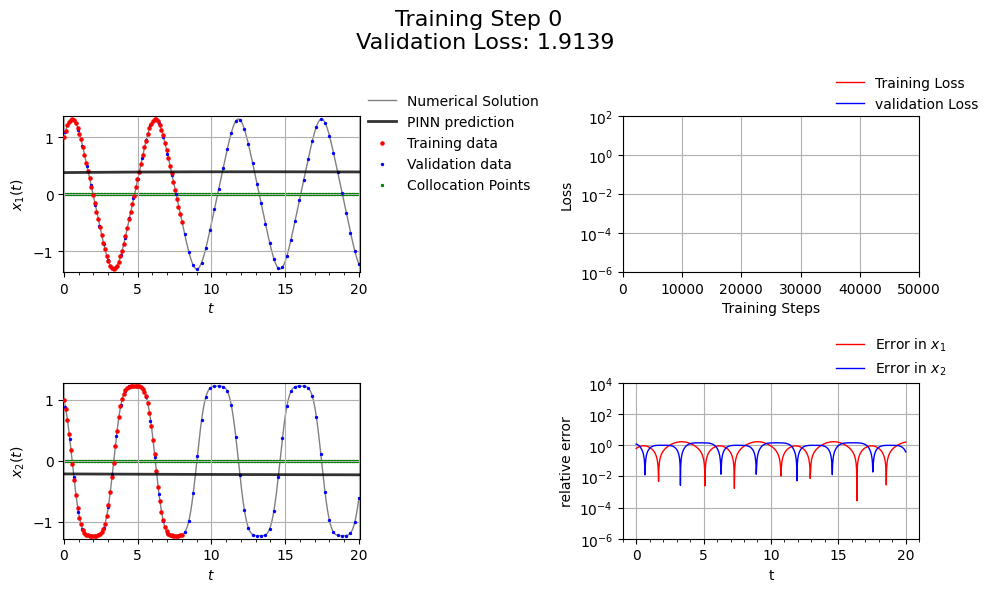

Training step 1000
x1 MSE = 8.9993e-05, x2 MSE = 5.7939e-05
Total Training Loss = 1.6915e-04, 
ODE Training Loss = 7.6606%, Data Training Loss = 87.4558%, derivative Training Loss = 4.8836%

x1 MSE = 9.3163e-01, x2 MSE = 1.4795e+00
Total Validation Loss = 2.4126e+00, 
ODE Validation Loss = 0.0599%, Data Validation Loss = 99.9401%
----------------------------------------------
Training step 2000
x1 MSE = 4.8784e-05, x2 MSE = 3.5600e-05
Total Training Loss = 1.0311e-04, 
ODE Training Loss = 13.1018%, Data Training Loss = 81.8381%, derivative Training Loss = 5.0601%

x1 MSE = 9.5627e-01, x2 MSE = 1.4739e+00
Total Validation Loss = 2.4316e+00, 
ODE Validation Loss = 0.0593%, Data Validation Loss = 99.9407%
----------------------------------------------
Training step 3000
x1 MSE = 3.4362e-05, x2 MSE = 3.2175e-05
Total Training Loss = 8.3776e-05, 
ODE Training Loss = 15.7569%, Data Training Loss = 79.4225%, derivative Training Loss = 4.8206%

x1 MSE = 9.5375e-01, x2 MSE = 1.4473e+00
Total Va

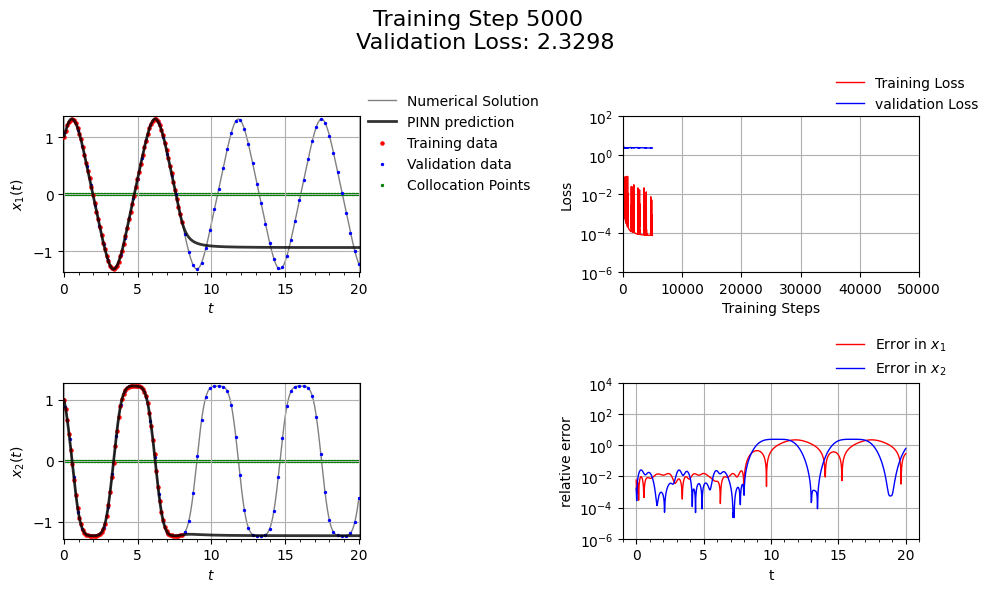

Training step 6000
x1 MSE = 1.1977e-04, x2 MSE = 1.3677e-04
Total Training Loss = 2.7286e-04, 
ODE Training Loss = 4.3873%, Data Training Loss = 94.0156%, derivative Training Loss = 1.5971%

x1 MSE = 9.3021e-01, x2 MSE = 1.3770e+00
Total Validation Loss = 2.3086e+00, 
ODE Validation Loss = 0.0621%, Data Validation Loss = 99.9379%
----------------------------------------------
Training step 7000
x1 MSE = 3.0299e-05, x2 MSE = 2.4509e-05
Total Training Loss = 7.0436e-05, 
ODE Training Loss = 16.7016%, Data Training Loss = 77.8117%, derivative Training Loss = 5.4867%

x1 MSE = 9.3155e-01, x2 MSE = 1.3570e+00
Total Validation Loss = 2.2899e+00, 
ODE Validation Loss = 0.0626%, Data Validation Loss = 99.9374%
----------------------------------------------
Training step 8000
x1 MSE = 3.0286e-05, x2 MSE = 2.3616e-05
Total Training Loss = 6.9356e-05, 
ODE Training Loss = 16.7389%, Data Training Loss = 77.7179%, derivative Training Loss = 5.5431%

x1 MSE = 9.3198e-01, x2 MSE = 1.3404e+00
Total Va

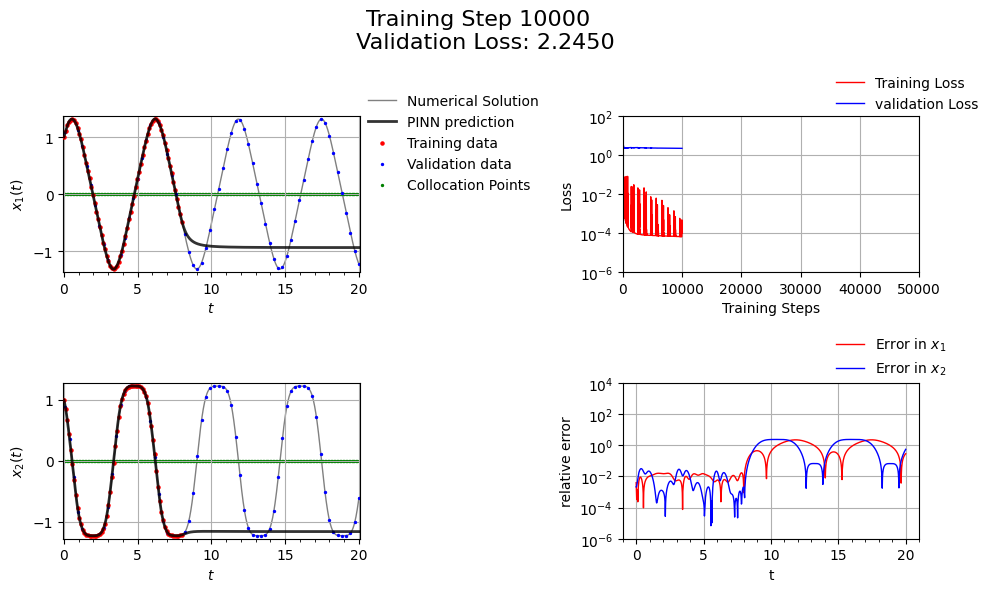

Training step 11000
x1 MSE = 2.8828e-05, x2 MSE = 1.9155e-05
Total Training Loss = 6.3078e-05, 
ODE Training Loss = 17.7889%, Data Training Loss = 76.0690%, derivative Training Loss = 6.1421%

x1 MSE = 9.3398e-01, x2 MSE = 1.2984e+00
Total Validation Loss = 2.2338e+00, 
ODE Validation Loss = 0.0640%, Data Validation Loss = 99.9360%
----------------------------------------------
Training step 12000
x1 MSE = 2.9133e-05, x2 MSE = 1.8966e-05
Total Training Loss = 6.3151e-05, 
ODE Training Loss = 17.5612%, Data Training Loss = 76.1647%, derivative Training Loss = 6.2741%

x1 MSE = 9.3211e-01, x2 MSE = 1.2891e+00
Total Validation Loss = 2.2226e+00, 
ODE Validation Loss = 0.0642%, Data Validation Loss = 99.9358%
----------------------------------------------
Training step 13000
x1 MSE = 2.8130e-05, x2 MSE = 1.7365e-05
Total Training Loss = 6.0512e-05, 
ODE Training Loss = 18.1270%, Data Training Loss = 75.1833%, derivative Training Loss = 6.6897%

x1 MSE = 9.2953e-01, x2 MSE = 1.2822e+00
Tota

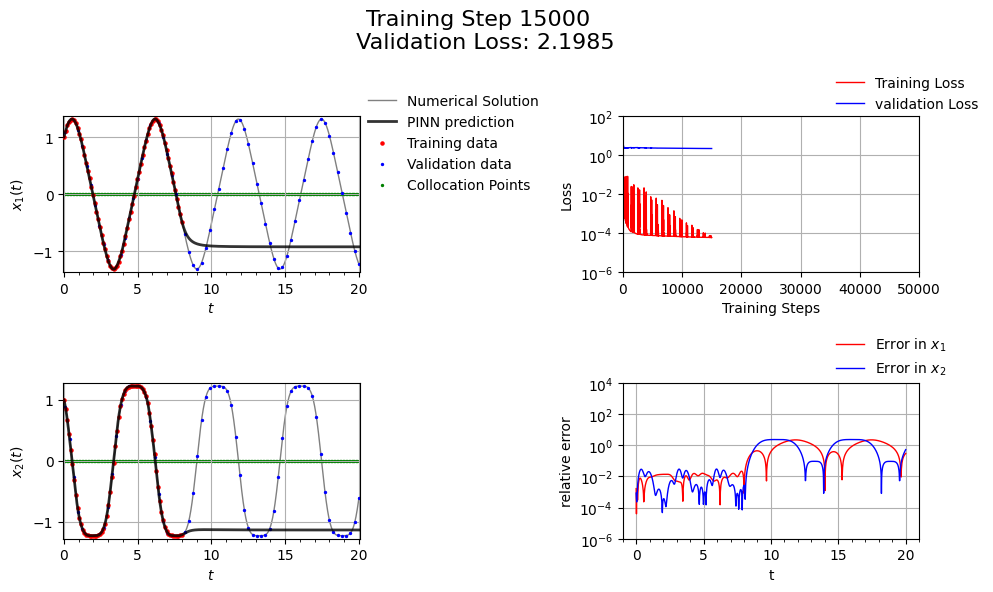

Training step 16000
x1 MSE = 2.7898e-05, x2 MSE = 1.6414e-05
Total Training Loss = 5.9247e-05, 
ODE Training Loss = 18.0142%, Data Training Loss = 74.7914%, derivative Training Loss = 7.1944%

x1 MSE = 9.1714e-01, x2 MSE = 1.2747e+00
Total Validation Loss = 2.1932e+00, 
ODE Validation Loss = 0.0650%, Data Validation Loss = 99.9350%
----------------------------------------------
Training step 17000
x1 MSE = 2.6920e-05, x2 MSE = 1.5938e-05
Total Training Loss = 5.7736e-05, 
ODE Training Loss = 18.3397%, Data Training Loss = 74.2309%, derivative Training Loss = 7.4293%

x1 MSE = 9.1213e-01, x2 MSE = 1.2754e+00
Total Validation Loss = 2.1889e+00, 
ODE Validation Loss = 0.0651%, Data Validation Loss = 99.9349%
----------------------------------------------
Training step 18000
x1 MSE = 2.6540e-05, x2 MSE = 1.5657e-05
Total Training Loss = 5.7025e-05, 
ODE Training Loss = 18.4288%, Data Training Loss = 73.9974%, derivative Training Loss = 7.5737%

x1 MSE = 9.0611e-01, x2 MSE = 1.2774e+00
Tota

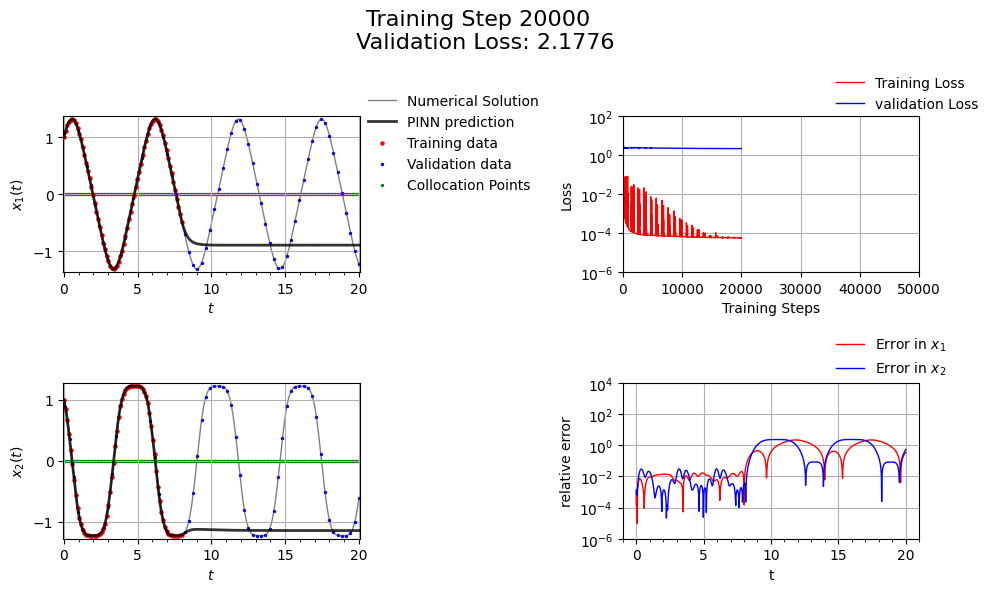

Training step 21000
x1 MSE = 2.5720e-05, x2 MSE = 1.5299e-05
Total Training Loss = 5.5661e-05, 
ODE Training Loss = 18.4837%, Data Training Loss = 73.6943%, derivative Training Loss = 7.8220%

x1 MSE = 8.8743e-01, x2 MSE = 1.2850e+00
Total Validation Loss = 2.1739e+00, 
ODE Validation Loss = 0.0656%, Data Validation Loss = 99.9344%
----------------------------------------------
Training step 22000
x1 MSE = 2.5462e-05, x2 MSE = 1.5217e-05
Total Training Loss = 5.5256e-05, 
ODE Training Loss = 18.4905%, Data Training Loss = 73.6185%, derivative Training Loss = 7.8910%

x1 MSE = 8.8136e-01, x2 MSE = 1.2870e+00
Total Validation Loss = 2.1698e+00, 
ODE Validation Loss = 0.0657%, Data Validation Loss = 99.9343%
----------------------------------------------
Training step 23000
x1 MSE = 2.5203e-05, x2 MSE = 1.5147e-05
Total Training Loss = 5.4860e-05, 
ODE Training Loss = 18.4907%, Data Training Loss = 73.5503%, derivative Training Loss = 7.9590%

x1 MSE = 8.7528e-01, x2 MSE = 1.2886e+00
Tota

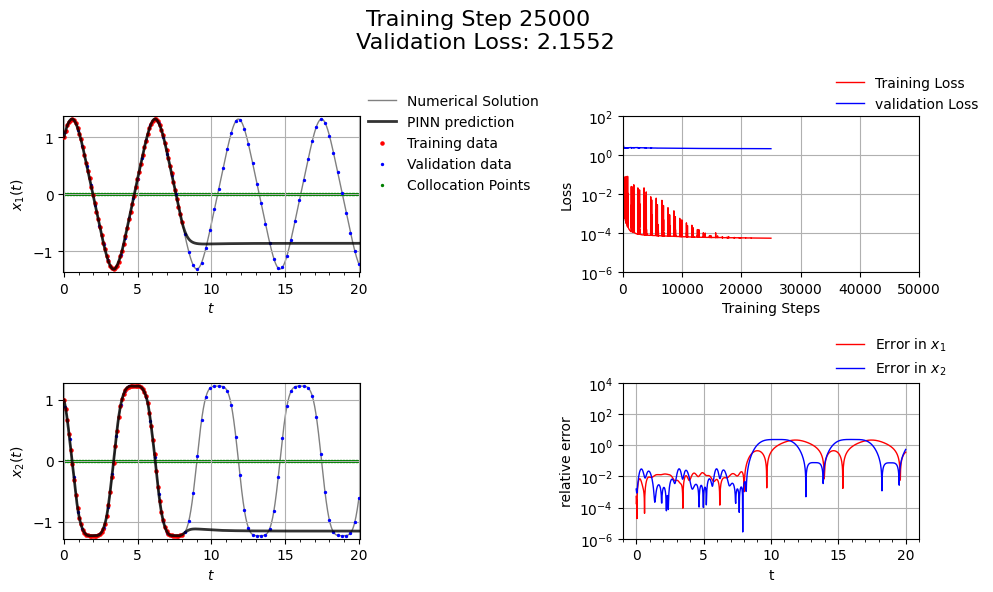

Training step 26000
x1 MSE = 2.4455e-05, x2 MSE = 1.4997e-05
Total Training Loss = 5.3762e-05, 
ODE Training Loss = 18.4585%, Data Training Loss = 73.3830%, derivative Training Loss = 8.1585%

x1 MSE = 8.5847e-01, x2 MSE = 1.2899e+00
Total Validation Loss = 2.1498e+00, 
ODE Validation Loss = 0.0663%, Data Validation Loss = 99.9337%
----------------------------------------------
Training step 27000
x1 MSE = 2.4218e-05, x2 MSE = 1.4962e-05
Total Training Loss = 5.3425e-05, 
ODE Training Loss = 18.4413%, Data Training Loss = 73.3361%, derivative Training Loss = 8.2226%

x1 MSE = 8.5358e-01, x2 MSE = 1.2892e+00
Total Validation Loss = 2.1442e+00, 
ODE Validation Loss = 0.0665%, Data Validation Loss = 99.9335%
----------------------------------------------
Training step 28000
x1 MSE = 2.3998e-05, x2 MSE = 1.4936e-05
Total Training Loss = 5.3116e-05, 
ODE Training Loss = 18.4185%, Data Training Loss = 73.3001%, derivative Training Loss = 8.2814%

x1 MSE = 8.4911e-01, x2 MSE = 1.2881e+00
Tota

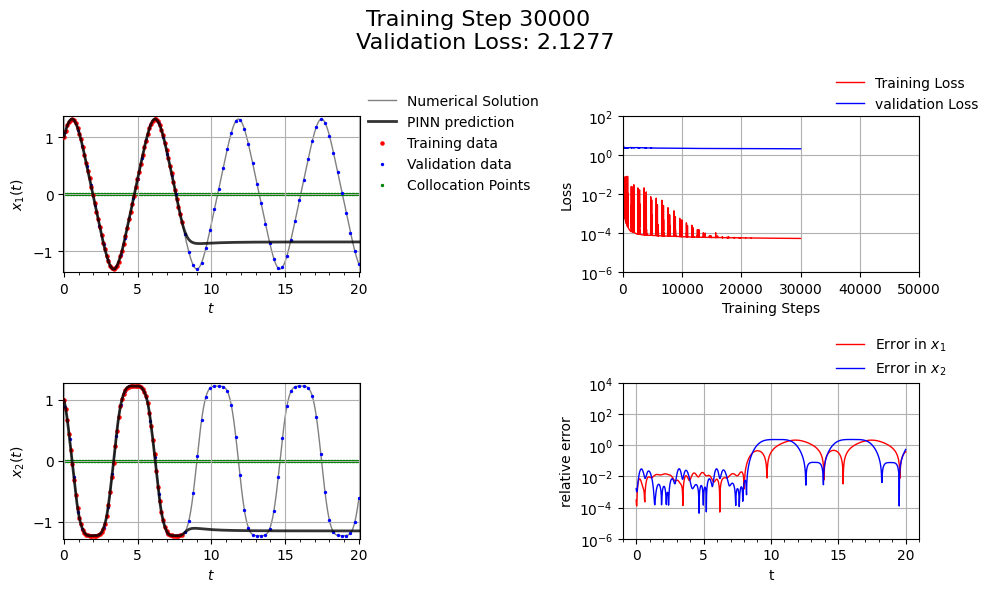

Training step 31000
x1 MSE = 2.3439e-05, x2 MSE = 1.4878e-05
Total Training Loss = 5.2328e-05, 
ODE Training Loss = 18.3402%, Data Training Loss = 73.2261%, derivative Training Loss = 8.4337%

x1 MSE = 8.3861e-01, x2 MSE = 1.2825e+00
Total Validation Loss = 2.1226e+00, 
ODE Validation Loss = 0.0671%, Data Validation Loss = 99.9329%
----------------------------------------------
Training step 32000
x1 MSE = 2.3289e-05, x2 MSE = 1.4866e-05
Total Training Loss = 5.2116e-05, 
ODE Training Loss = 18.3132%, Data Training Loss = 73.2123%, derivative Training Loss = 8.4745%

x1 MSE = 8.3608e-01, x2 MSE = 1.2803e+00
Total Validation Loss = 2.1178e+00, 
ODE Validation Loss = 0.0672%, Data Validation Loss = 99.9328%
----------------------------------------------
Training step 33000
x1 MSE = 2.3158e-05, x2 MSE = 1.4857e-05
Total Training Loss = 5.1931e-05, 
ODE Training Loss = 18.2874%, Data Training Loss = 73.2027%, derivative Training Loss = 8.5099%

x1 MSE = 8.3396e-01, x2 MSE = 1.2781e+00
Tota

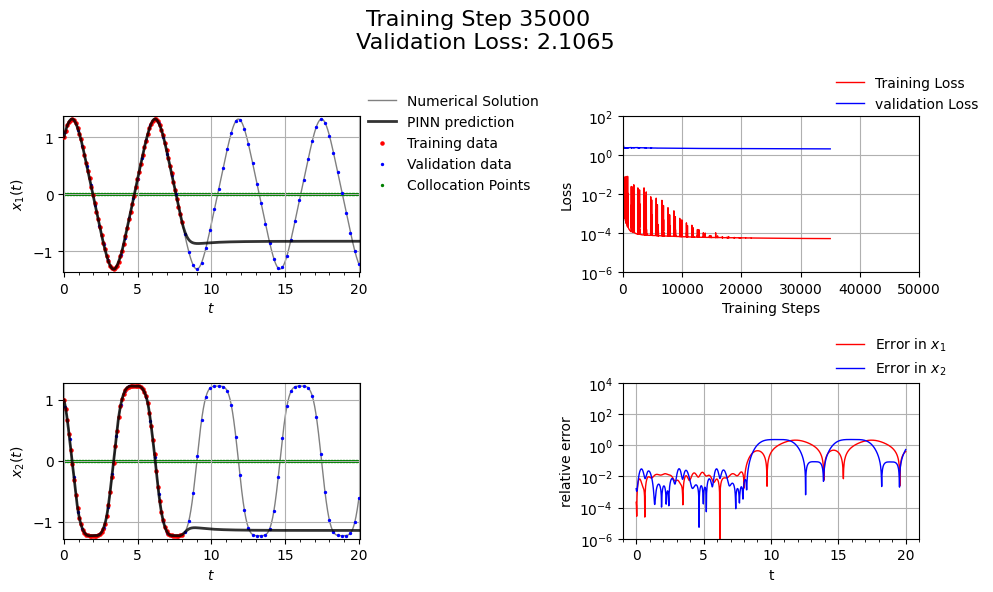

Training step 36000
x1 MSE = 2.2870e-05, x2 MSE = 1.4841e-05
Total Training Loss = 5.1528e-05, 
ODE Training Loss = 18.2281%, Data Training Loss = 73.1849%, derivative Training Loss = 8.5870%

x1 MSE = 8.2962e-01, x2 MSE = 1.2727e+00
Total Validation Loss = 2.1038e+00, 
ODE Validation Loss = 0.0676%, Data Validation Loss = 99.9324%
----------------------------------------------
Training step 37000
x1 MSE = 2.2805e-05, x2 MSE = 1.4839e-05
Total Training Loss = 5.1439e-05, 
ODE Training Loss = 18.2150%, Data Training Loss = 73.1814%, derivative Training Loss = 8.6036%

x1 MSE = 8.2868e-01, x2 MSE = 1.2715e+00
Total Validation Loss = 2.1016e+00, 
ODE Validation Loss = 0.0677%, Data Validation Loss = 99.9323%
----------------------------------------------
Training step 38000
x1 MSE = 2.2752e-05, x2 MSE = 1.4837e-05
Total Training Loss = 5.1367e-05, 
ODE Training Loss = 18.2051%, Data Training Loss = 73.1779%, derivative Training Loss = 8.6170%

x1 MSE = 8.2792e-01, x2 MSE = 1.2705e+00
Tota

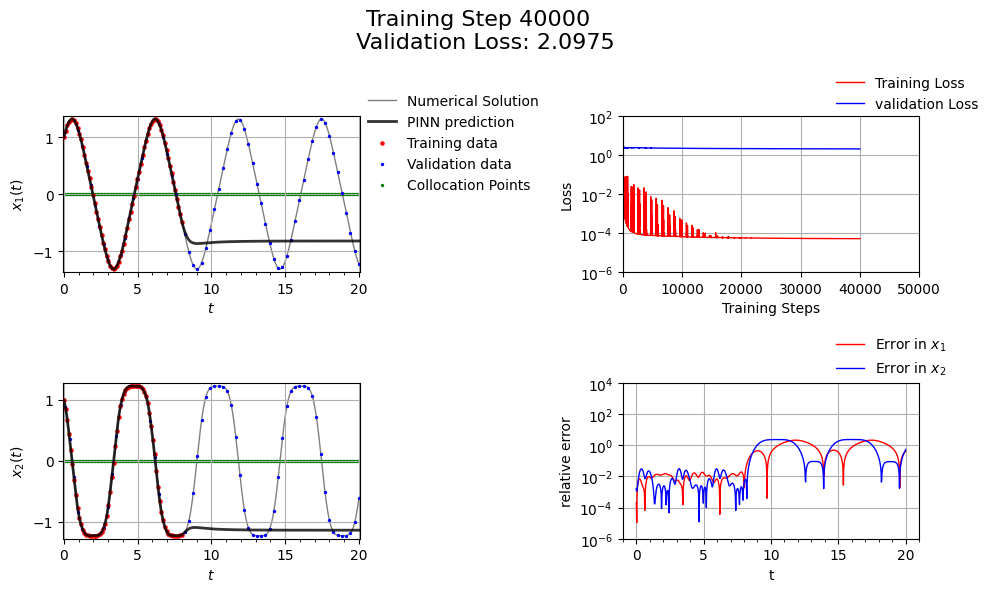

Training step 41000
x1 MSE = 2.2654e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1234e-05, 
ODE Training Loss = 18.1870%, Data Training Loss = 73.1730%, derivative Training Loss = 8.6401%

x1 MSE = 8.2643e-01, x2 MSE = 1.2689e+00
Total Validation Loss = 2.0967e+00, 
ODE Validation Loss = 0.0678%, Data Validation Loss = 99.9322%
----------------------------------------------
Training step 42000
x1 MSE = 2.2636e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1209e-05, 
ODE Training Loss = 18.1833%, Data Training Loss = 73.1729%, derivative Training Loss = 8.6438%

x1 MSE = 8.2613e-01, x2 MSE = 1.2686e+00
Total Validation Loss = 2.0961e+00, 
ODE Validation Loss = 0.0678%, Data Validation Loss = 99.9322%
----------------------------------------------
Training step 43000
x1 MSE = 2.2622e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1189e-05, 
ODE Training Loss = 18.1811%, Data Training Loss = 73.1717%, derivative Training Loss = 8.6472%

x1 MSE = 8.2591e-01, x2 MSE = 1.2684e+00
Tota

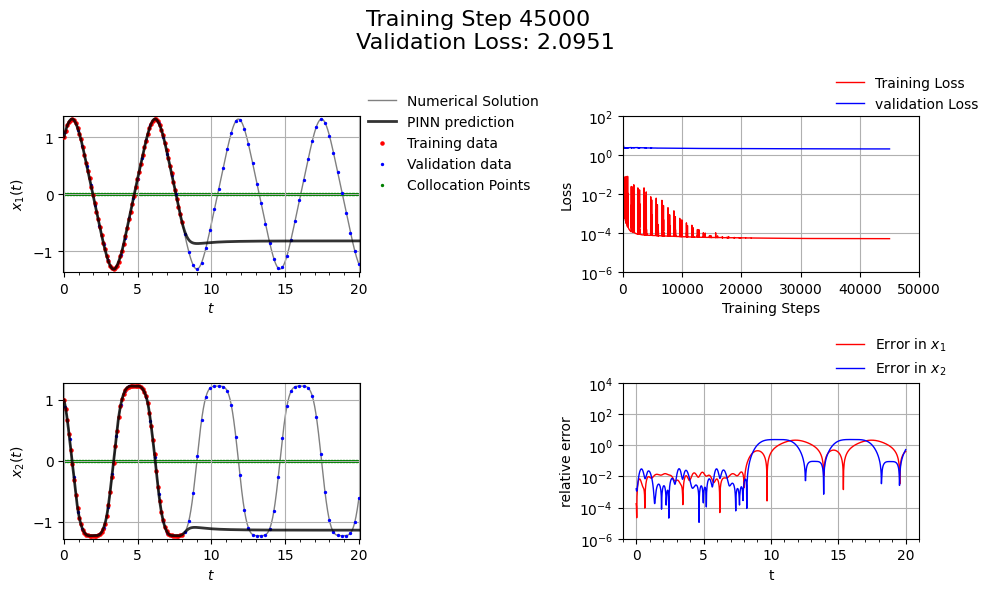

Training step 46000
x1 MSE = 2.2596e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1155e-05, 
ODE Training Loss = 18.1770%, Data Training Loss = 73.1714%, derivative Training Loss = 8.6516%

x1 MSE = 8.2549e-01, x2 MSE = 1.2680e+00
Total Validation Loss = 2.0949e+00, 
ODE Validation Loss = 0.0679%, Data Validation Loss = 99.9321%
----------------------------------------------
Training step 47000
x1 MSE = 2.2591e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1148e-05, 
ODE Training Loss = 18.1764%, Data Training Loss = 73.1707%, derivative Training Loss = 8.6529%

x1 MSE = 8.2542e-01, x2 MSE = 1.2679e+00
Total Validation Loss = 2.0948e+00, 
ODE Validation Loss = 0.0679%, Data Validation Loss = 99.9321%
----------------------------------------------
Training step 48000
x1 MSE = 2.2588e-05, x2 MSE = 1.4835e-05
Total Training Loss = 5.1144e-05, 
ODE Training Loss = 18.1752%, Data Training Loss = 73.1719%, derivative Training Loss = 8.6530%

x1 MSE = 8.2535e-01, x2 MSE = 1.2679e+00
Tota

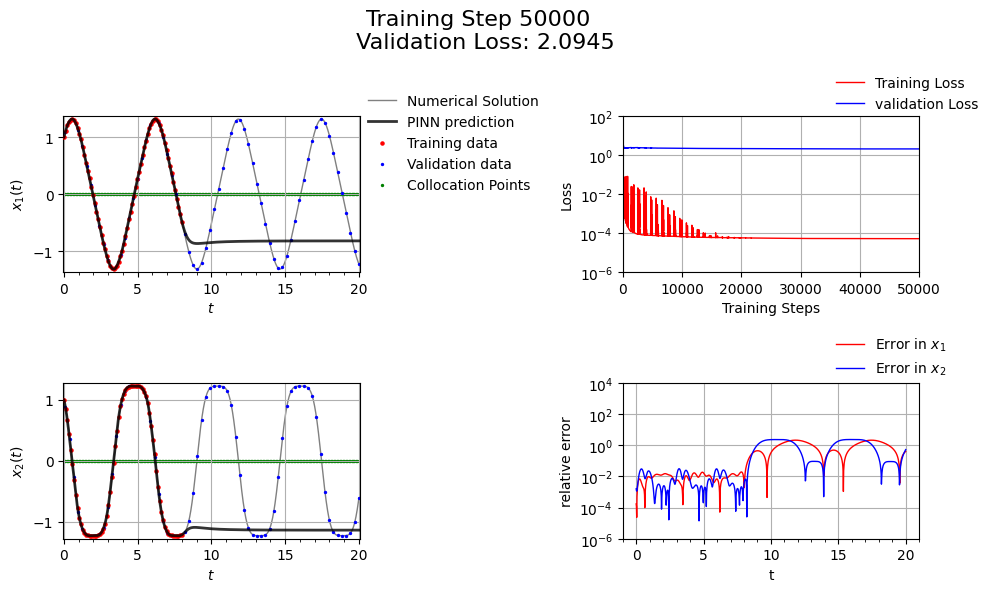

In [32]:
# PINN
torch.manual_seed(123)

# Define PINN model. 1 input, 1 output, 3 hidden layers of 32 nodes.
PINN = FCN()

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-2)

# Exponential scheduler, multiplies learning rate (lr) by gamma every 2000 epochs; set gamma to 1 to disable
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

# Number of training steps
epochs = 50_000 + 1

# Weights for loss function
l1, l2  = 1e-3, 1e-5

# stores loss values
training_loss, validation_loss = [], []
physics_losses, data_losses, derivative_losses = [], [], []


torch.autograd.set_detect_anomaly(False)
for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for position
    U  = PINN(t_training)
    u1 = U[:,0].view(-1,1)
    u2 = U[:,1].view(-1,1)
    data_loss = ((u1 - x1_data)**2 + (u2 - x2_data)**2).mean()
    
    du1 = torch.autograd.grad(u1, t_training, torch.ones_like(u1), create_graph=True, retain_graph=True)[0]
    du2 = torch.autograd.grad(u2, t_training, torch.ones_like(u2), create_graph=True, retain_graph=True)[0]
    derivative_loss = ((du1 - f1(x1_data, x2_data, t_training))**2 + (du2 - f2(x1_data, x2_data, t_training))**2).mean()
    
    # Compute the ODE loss
    V   = PINN(t_physics)
    v1  = V[:,0].view(-1,1)
    v2  = V[:,1].view(-1,1)
    dv1 = torch.autograd.grad(v1, t_physics, torch.ones_like(v1), create_graph=True)[0]
    dv2 = torch.autograd.grad(v2, t_physics, torch.ones_like(v2), create_graph=True)[0]
    loss_ODE = ((dv1 - f1(v1, v2, t_physics))**2 + (dv2 - f2(v1,v2,t_physics))**2).mean()
    
    # Compute total loss
    loss = data_loss + l1*derivative_loss + l2*loss_ODE
    
    training_loss.append(loss.item())
    physics_losses.append(loss_ODE.item())
    data_losses.append(data_loss.item())
    derivative_losses.append(derivative_loss.item())
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    
    # every 1000 epochs, multiply learning rate by gamma
    if (i+1) % 1000 == 0: scheduler.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    U_val = PINN(t_validation)
    u1_val = U_val[:,0].view(-1,1)
    u2_val = U_val[:,1].view(-1,1)
    
    loss_value_val = torch.mean((u1_val - x1_val)**2 + (u2_val - x2_val)**2)

    du1_val = torch.autograd.grad(u1_val, t_validation, torch.ones_like(u1_val), create_graph=True)[0]
    du2_val = torch.autograd.grad(u2_val,  t_validation, torch.ones_like(u2_val),  create_graph=True)[0]
    loss_ODE_val = torch.mean((du1_val - f1(x1_val, x2_val, t_validation))**2 + (du2_val - f2(x1_val, x2_val, t_validation))**2)
    
    loss_val = loss_value_val + l1*loss_ODE_val
    validation_loss.append(loss_val.item())
    
    # ===
    # Plotting
    # ===
    
    if (i % 1_000) == 0: 
        P  = PINN(t).detach()
        make_plot(
            i=i, loss_val=loss_val, epochs=epochs,
            t=t, t_data=t_data, t_validation=t_val, t_collocation=t_physics.detach(),
            solution_1=x1, prediction_1=P[:,0],
            solution_2=x2, prediction_2=P[:,1],
            data_1=x1_data, data_2=x2_data,
            validation_1=x1_val, validation_2=x2_val,
            x1_max=x1_max, x2_max=x2_max,
            training_loss=training_loss, validation_loss=validation_loss
        )
        print(f"Training step {i}")
        print(f"x1 MSE = {((u1 - x1_data)**2).mean().item():.4e}, x2 MSE = {((u2 - x2_data)**2).mean().item():.4e}")
        print(f"Total Training Loss = {loss.item():.4e}, \n"+
              f"ODE Training Loss = {l2*loss_ODE.item()/loss * 100:.4f}%, "+
              f"Data Training Loss = {data_loss.item()/loss * 100:.4f}%, "+
              f"derivative Training Loss = {l1*derivative_loss.item()/loss * 100:.4f}%\n")
        
        print(f"x1 MSE = {((u1_val - x1_val)**2).mean().item():.4e}, x2 MSE = {((u2_val - x2_val)**2).mean().item():.4e}")
        print(f"Total Validation Loss = {loss_val.item():.4e}, \n"+
              f"ODE Validation Loss = {l1*loss_ODE_val.item()/loss_val * 100:.4f}%, "+
              f"Data Validation Loss = {loss_value_val.item()/loss_val * 100:.4f}%")
        print("----------------------------------------------")
        
        if i == (epochs-1):
            plt.savefig("pinn_ode_solution.png", dpi=300)
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

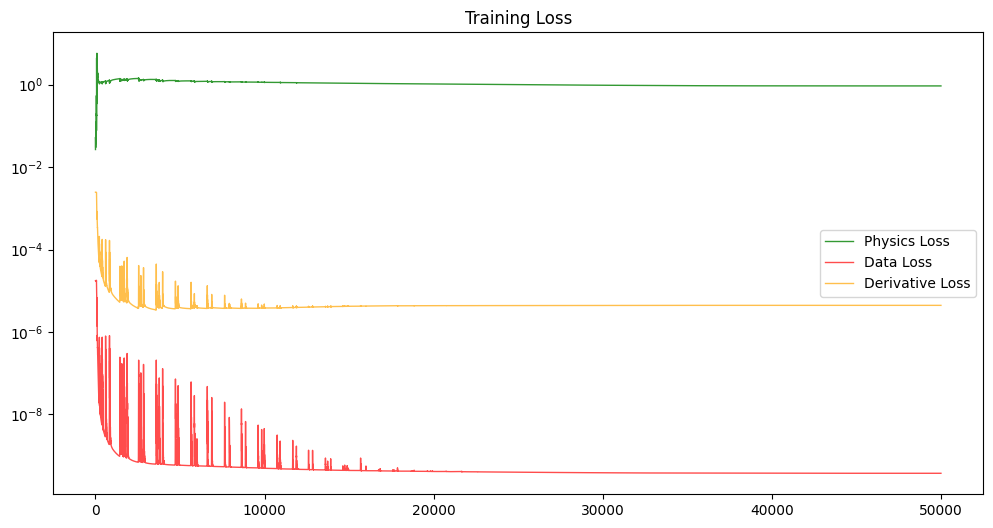

In [33]:
plt.subplots(figsize=(12,6))
plt.plot(np.arange(epochs), physics_losses, label="Physics Loss", color='green', lw=1, alpha=0.8, linestyle = '-')
plt.plot(np.arange(epochs), l2*torch.tensor(data_losses), label="Data Loss", color='red', lw=1, alpha=0.7)
plt.plot(np.arange(epochs), l1*torch.tensor(derivative_losses), label="Derivative Loss", color='orange', lw=1, alpha=0.7)
plt.title("Training Loss")
plt.legend()
plt.yscale('log')
plt.savefig('loss.png')
plt.show()